# Execute a simple, custom, model

### Import cobrakbase

In [3]:
from pprint import pprint
# define the environment path 
import os
local_cobrakbase_path = os.path.join('C:', 'Users', 'Andrew Freiburger','Documents','Argonne','cobrakbase')
os.environ["HOME"] = local_cobrakbase_path

# import the models
from cobrakbase import KBaseAPI, Metabolite, Reaction, Model
token = 'WE6CHYRDTJSGOHFIDGPE7WYFT6PRPXJL'
kbase_api = KBaseAPI(token)

### Define the model

In [40]:
# define metabolites
ACP_c = Metabolite(
    'cpd11628',
    name='acyl-carrier-protein',
    compartment='c')
omrsACP_c = Metabolite(
    'cpd15377',
    formula='C25H45N2O9PRS',
    name='3-Oxotetradecanoyl-acyl-carrier-protein',
    compartment='c')
co2_c = Metabolite('cpd00011', formula='CO2', name='CO2', compartment='c')
malACP_c = Metabolite(
    'cpd11492',
    formula='C14H22N2O10PRS',
    name='Malonyl-acyl-carrier-protein',
    compartment='c')
h_c = Metabolite('cpd00067', formula='H', name='H', compartment='c')
ddcaACP_c = Metabolite(
    'cpd11468',
    formula='C23H43N2O8PRS',
    name='Dodecanoyl-ACP-n-C120ACP',
    compartment='c')

# define reactions, with the metabolites
reaction = Reaction('R_3OAS140')
reaction.name = 'R_3OAS140'
reaction.add_metabolites({
    malACP_c: -1.0,
    h_c: -1.0,
    ddcaACP_c: -1.0,
    co2_c: 1.0,
    ACP_c: 1.0,
    omrsACP_c: 1.0
})

reaction2 = Reaction('rxn2')
reaction2.add_metabolites({
    malACP_c: -1.0,
    h_c: 1.0,
    ddcaACP_c: -1.0,
    co2_c: -1.0,
    ACP_c: 1.0
})
reaction2.name = 'rxn2'

# define the model, with the reactions
model = Model('test')
model.add_reactions([reaction, reaction2])
model.objective = reaction.flux_expression

for reaction in model.reactions:
    print(reaction)

R_3OAS140: cpd00067 + cpd11468 + cpd11492 --> cpd00011 + cpd11628 + cpd15377
rxn2: cpd00011 + cpd11468 + cpd11492 --> cpd00067 + cpd11628


### Execute the model with custom kinetic data

C:\Users\Andrew Freiburger\AppData\Roaming\Python\Python37\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


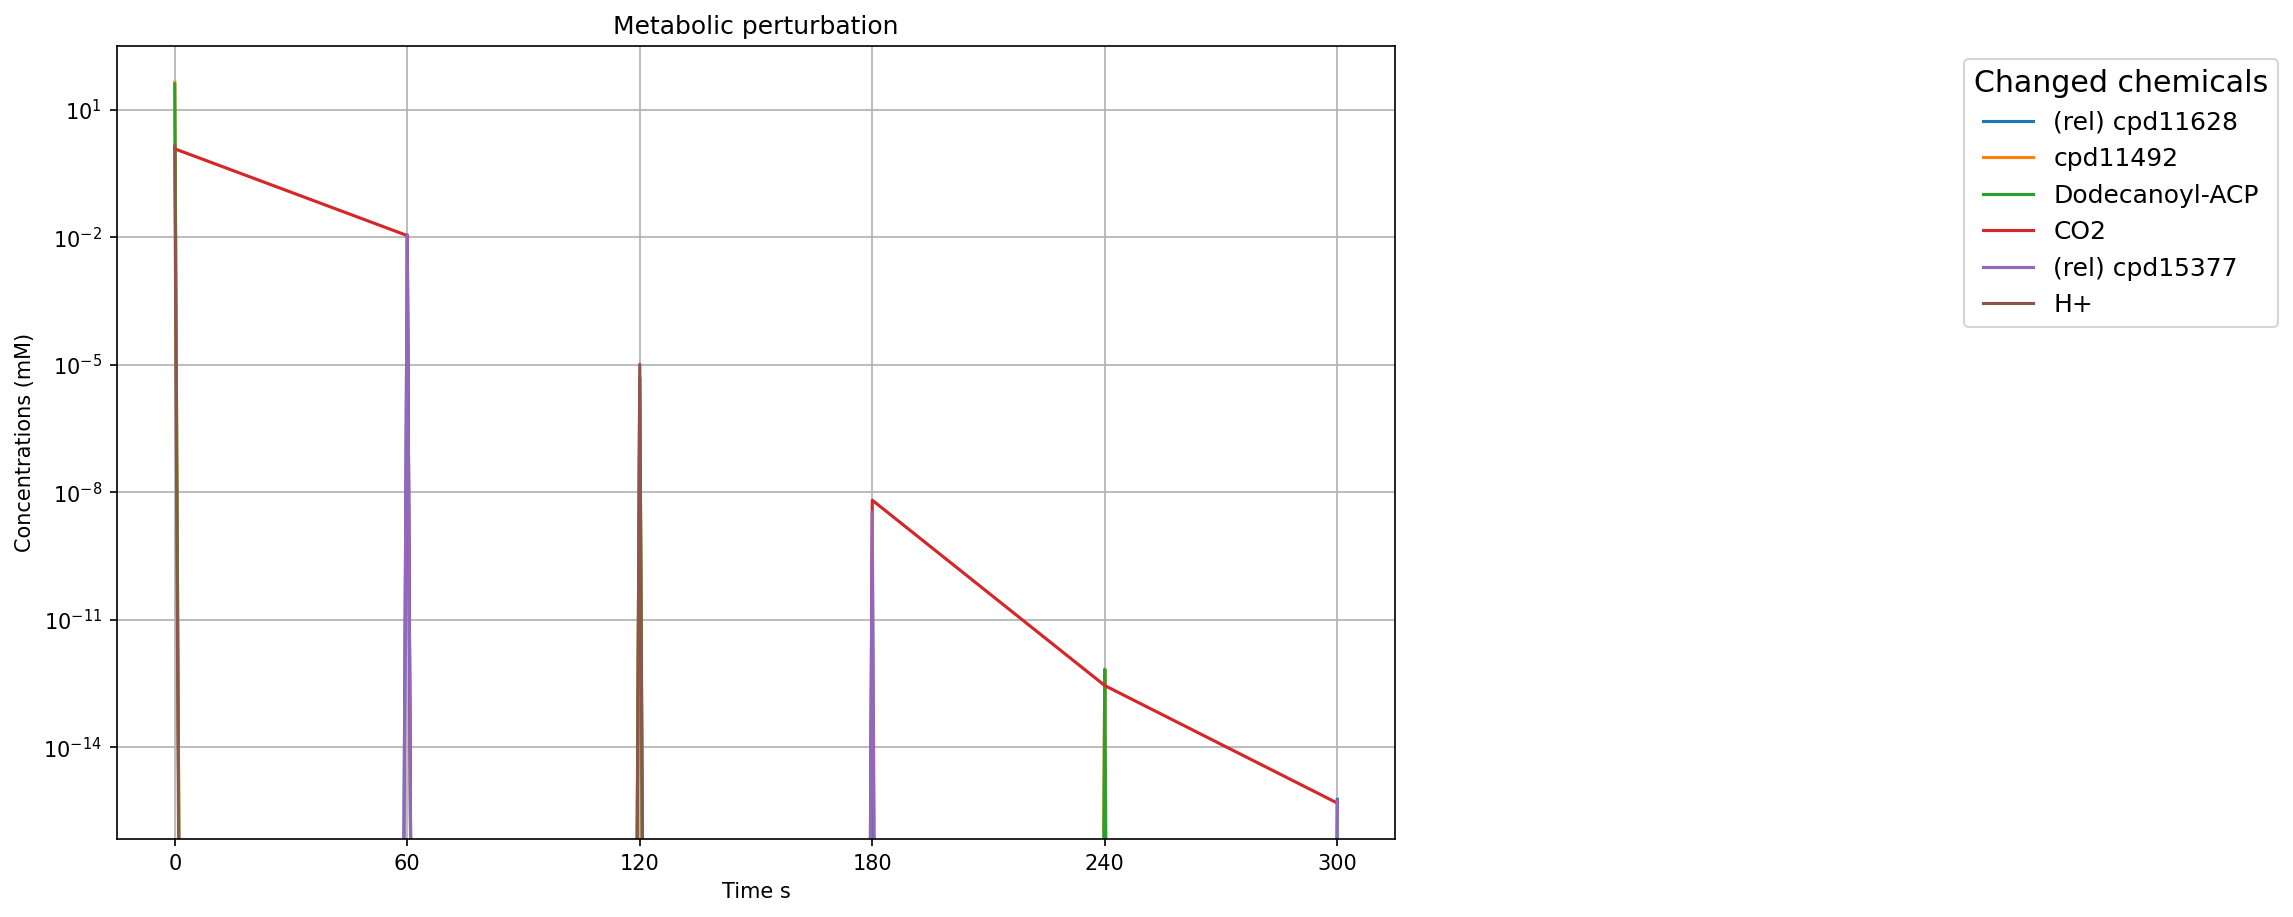

In [41]:
%run ../../modelseedpy/fbapkg/dfbapkg.py

# define arbitrary enzyme kinetics and rate equations
reaction_kinetics = {
    'R_3OAS140': {
        'source_1': {
            'substituted_rate_law': '(68.0*A*B)/(50.0*0.34*C+360.0*B+0.34*A+A*B*C)',
            "initial_concentrations_M": {
                "A": .0200,
                'C':.022,
                'B': .0014
            },
            "met_id": {
                'A': 'cpd11468',
                'B': 'cpd00067',
                'C': 'cpd11492'
            }
        }
    },
    'rxn2': {
        'source_1': {
            'substituted_rate_law': '(A*B)/(50.0*0.34*C+3*B+0.34*A+C)',
            "initial_concentrations_M": {
                "A": .0200,
                'C':.022,
                'B': .0012
            },
            "met_id": {
                'A': 'cpd11468',
                'B': 'cpd00011',
                'C': 'cpd11492'
            }
        }
    }
}

modelseed_db_path = os.path.join('..', '..', '..', 'ModelSEEDDatabase')
total_time = 5
timestep = 1
dfba = dFBA(model, modelseed_db_path, verbose = False)
conc, fluxes = dfba.simulate(None, None, total_time, timestep, None, None, kinetics_data = reaction_kinetics, labeled_plots = False, export = False)

# Execute SABIO-RK kinetics data 

In [42]:
display(dfba.concentrations)

,0 min,1 min,2 min,3 min,4 min,5 min
metabolite (ΔmM),,,,,,
Acyl-[acyl-carrier protein],0.0,0.011352,-0.000005,2.838471e-10,-6.764172e-13,5.878613e-16
Malonyl-acyl-carrierprotein-,44.0,-0.011352,0.000005,-2.838471e-10,6.764172e-13,-5.878613e-16
Dodecanoyl-ACP,40.0,-0.011352,0.000005,-2.838471e-10,6.764172e-13,-5.878613e-16
CO2,1.2,0.010913,-0.000010,6.467095e-09,2.804990e-13,4.818723e-16
3-Oxooctadecanoyl-[acyl-carrier protein],0.0,0.011133,-0.000008,3.375471e-09,-1.979591e-13,5.348668e-16
H+,1.4,-0.010913,0.000010,-6.467095e-09,-2.804990e-13,-4.818723e-16


In [3]:
%run ../../modelseedpy/fbapkg/dynamicfbapkg.py
import cobra 
model = cobra.io.read_sbml_model('../iSB619.xml')

# define in the initial conditions
initial_concentrations = {"ATP":200, "ADP":100}

# import enzyme kinetics and rate equations
with open('../sabio_proccessed.json', 'rb') as f:
    reaction_kinetics = json.load(f)

# execute the package
total_time = 5
timestep = 1
dfba = dynamicFBAPkg(model, total_time, timestep, initial_concentrations, reaction_kinetics, verbose = False)
fluxes_df, concentrations_df, solutions = dfba.simulate()

--> ERROR: The (E*1278.0*A)/(2.13+A) rate law is not solvable.
--> ERROR: The (E*37.0*A)/(7.0+A) rate law is not solvable.
--> ERROR: The (E*2.7*A)/(5.0+A) rate law is not solvable.
--> ERROR: The (E*23.0*A)/(3.2+A) rate law is not solvable.
--> ERROR: The (E*107.0*A)/(4.3+A) rate law is not solvable.
--> ERROR: The (E*422.0*A)/(4.5+A) rate law is not solvable.
--> ERROR: The (E*191.0*A)/(6.8+A) rate law is not solvable.
--> ERROR: The (E*92.0*A)/(7.3+A) rate law is not solvable.
--> ERROR: The (E*414.0*A)/(3.7+A) rate law is not solvable.
--> ERROR: The (E*143.0*A)/(5.8+A) rate law is not solvable.
--> ERROR: The (E*425.0*A)/(3.62+A) rate law is not solvable.
--> ERROR: The (E*0.59*A)/(3.1+A) rate law is not solvable.
--> ERROR: The (E*0.39*A)/(5.2+A) rate law is not solvable.
--> ERROR: The (E*1.46*A)/(5.0+A) rate law is not solvable.
--> ERROR: The (E*1125.0*A)/(3.0+A) rate law is not solvable.
--> ERROR: The (E*11.4*A)/(7.7+A) rate law is not solvable.
--> ERROR: The (E*1056.0*B)/(

C:\Users\Andrew Freiburger\AppData\Roaming\Python\Python37\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
C:\Users\Andrew Freiburger\Dropbox\My PC (DESKTOP-M302P50)\Documents\UVic Civil Engineering\Internships\Agronne\TFA\ModelSEEDpy\modelseedpy\fbapkg\DynamicFBA.py:1: RuntimeWarning: invalid value encountered in double_scalars
  # -*- coding: utf-8 -*-
C:\Users\Andrew Freiburger\Dropbox\My PC (DESKTOP-M302P50)\Documents\UVic Civil Engineering\Internships\Agronne\TFA\ModelSEEDpy\modelseedpy\fbapkg\DynamicFBA.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  # -*- coding: utf-8 -*-



--> ERROR: The (E*0.34*B)/(390.0+B) rate law is not solvable.
--> ERROR: The (E*1047.0*B)/(111.0+B) rate law is not solvable.
--> ERROR: The 17.2*E*2.36/(23.6+2.36) rate law is not solvable.
--> ERROR: The 14.1*E*4.03/(34.8+4.03) rate law is not solvable.
--> ERROR: The 12.9*E*4.03/(561.0+4.03) rate law is not solvable.
--> ERROR: The 9.5*E*2.31/(31.7+2.31) rate law is not solvable.
--> ERROR: The 16.3*E*2.31/(23.1+2.31) rate law is not solvable.
--> ERROR: The 11.2*E*0.77/(7.7+0.77) rate law is not solvable.
--> ERROR: The 63.0*E*S/(0.6+S) rate law is not solvable.
--> ERROR: The 83.0*E*S/(0.4+S) rate law is not solvable.
--> ERROR: The 57.0*E*S/(1.3+S) rate law is not solvable.
--> ERROR: The 0.06*E*S/(0.1+S) rate law is not solvable.
--> ERROR: The 9.0*E*S/(0.16+S) rate law is not solvable.
--> ERROR: The 7.0*E*S/(0.04+S) rate law is not solvable.
--> ERROR: The 4.0*E*S/(0.15+S) rate law is not solvable.
--> ERROR: The 18.0*E*S/(0.3+S) rate law is not solvable.
--> ERROR: The 22.0*